# 적대적 생성 신경망(Generative Adversarial Networks, GAN)

### GAN 생성자 네트워크

In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

In [2]:
latent_dim = 32
height, width, channels = 32, 32, 3

In [3]:
generator_input = Input(shape=(latent_dim,))

In [4]:
x = Dense(128 * 16 * 16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16, 16, 128))(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels, 7, activation='tanh', padding='same')(x)

In [5]:
generator = Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

### GAN 판별자 네트워크


In [6]:
discriminator_input = Input(shape=(height, width, channels))

In [7]:
x = Conv2D(128, 3)(discriminator_input)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

In [8]:
discriminator = Model(discriminator_input, x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6, 6, 128)         0   

In [10]:
discriminator_optimizer = RMSprop(learning_rate=0.0008, clipvalue=1.0, weight_decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

### 적대적 네트워크

In [11]:
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(learning_rate=0.0004, clipvalue=1.0, weight_decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### GAN 훈련 구현

In [12]:
import os
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image

- CIFAR10 데이터 로드

In [13]:
(x_train, y_train), (_, _) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


- 개구리 이미지를 선택

In [14]:
x_train = x_train[y_train.flatten() == 6]
x_train.shape

(5000, 32, 32, 3)

- 데이터 정규화

In [15]:
x_train = x_train.astype('float32') / 255.

In [16]:
iterations = 20000
batch_size = 20

save_dir = './gan_images'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

- 학습
    - 20000번 반복하는데 GPU version으로 약 50분 이상
 소요됨

In [17]:
start = 1
for step in range(1, iterations+1):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors, verbose=0)

    stop = start + batch_size
    real_images = x_train[start:stop]
    combined_images = np.concatenate([generated_images, real_images])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)

    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    if step % 500 == 0:
        gan.save_weights('gan.h5')
        print(f'\nstep: {step}')
        print(f'  discriminator loss: {d_loss}')
        print(f'  adversarial loss: {a_loss}')

        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, f'generated_frog{step}.png'))
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, f'real_frog{step}.png'))


step: 500
  discriminator loss: 0.6814966201782227
  adversarial loss: 0.7930293679237366

step: 1000
  discriminator loss: 0.6900736093521118
  adversarial loss: 0.7195833325386047

step: 1500
  discriminator loss: 0.694412112236023
  adversarial loss: 0.6897554397583008

step: 2000
  discriminator loss: 0.6950809359550476
  adversarial loss: 0.7223784923553467

step: 2500
  discriminator loss: 0.6887317895889282
  adversarial loss: 0.7576156854629517

step: 3000
  discriminator loss: 0.6867880821228027
  adversarial loss: 0.7223106622695923

step: 3500
  discriminator loss: 0.6967419981956482
  adversarial loss: 0.7942267656326294

step: 4000
  discriminator loss: 0.6982589960098267
  adversarial loss: 0.6953030228614807

step: 4500
  discriminator loss: 0.6946333050727844
  adversarial loss: 0.7637540102005005

step: 5000
  discriminator loss: 0.6964350938796997
  adversarial loss: 0.7099583148956299

step: 5500
  discriminator loss: 0.6955233216285706
  adversarial loss: 0.7652574

- 만든 이미지 확인

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

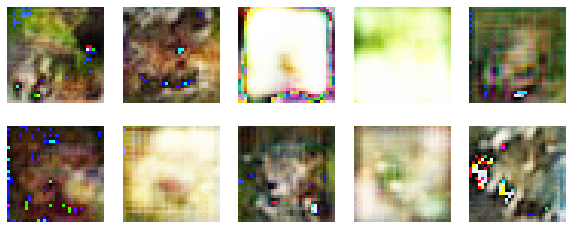

In [20]:
plt.figure(figsize=(10,4))
for i in range(10):
    fname = 'gan_images/generated_frog' + str(i*1000 + 11000) + '.png'
    img = Image.open(fname)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

- 이미지 생성을 통한 시각화


In [21]:
# 잠재 공간에서 랜덤한 포인트를 샘플링
random_latent_vectors = np.random.normal(size=(10, latent_dim))

In [22]:
# 가짜 이미지로 디코딩
generated_images = generator.predict(random_latent_vectors)
generated_images.shape

1/1 [==============================] - 0s 399ms/step


(10, 32, 32, 3)

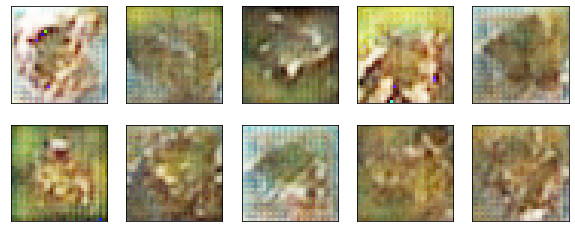

In [23]:
plt.figure(figsize=(10,4))
for i in range(generated_images.shape[0]):
    plt.subplot(2, 5, i+1)
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])

plt.show()